## Part_2

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import yfinance as yf
import finta


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import gc; gc.enable()

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split,cross_validate

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix


from scipy.signal import argrelextrema
from scipy.signal import savgol_filter

from sklearn.model_selection import StratifiedKFold

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from category_encoders import WOEEncoder, TargetEncoder
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

# from pygam import LogisticGAM, s, te

In [16]:
# from functions import smooth, loc_minima, loc_maxima, loc_extrema, calc_slope, calc_acc
# from functions import col_rename, split_check,reduce_df, display, plot, plot_df

### Functions

In [30]:
def smooth(series):
    
    series = savgol_filter(series, 21, 2)
    series = savgol_filter(series, 11, 2)
    series = savgol_filter(series, 11, 1)
    return series
    
def loc_minima(series, order=10):
    '''
    Function returns pandas series with values 1&0: if local minima = 1, otherwise = 0.
    Where,
    series: e.g. = df.close
    order: number of days(both sides) of the local minimum point.
    
    '''
    # get the indeces of local minima with specified order(number of days from local min)
    local_min = argrelextrema(series.values, np.less_equal, order=order)[0].tolist()
    
    # get pandas series with 0s.
    min_series = 0*series
    
    # update series by assigning 1s to local minima(using list of indeces: local_min) 
    min_series[local_min] = 1
    
    gc.collect()
    return min_series

def loc_maxima(series, order=10):
    '''
    Function returns pandas series with values 1&0: if local maxima = 1, otherwise = 0.
    Where,
    series: e.g. = df.close
    order: number of days(both sides) of the local maximum point.
    
    '''
    
    # get the indeces of local maxima with specified order(number of days from local max)
    local_max = argrelextrema(series.values, np.greater_equal, order=order)[0].tolist()
    
    # get pandas series with 0s.
    max_series = 0*series
    
    # update series by assigning 1s to local maxima(using list of indeces: local_max) 
    max_series[local_max] = 1

    gc.collect()
    return max_series

def loc_extrema(series, order=10):
    
    '''
    Function returns pandas series with values 0,1,-1: 
    if local minima = 1, if local maxima = -1, otherwise = 0.
    
    Where,
    series: e.g. = df.close
    order: number of days(both sides) of the local extremum point.
    
    '''
    loc_max = loc_maxima(series,order)
    loc_min = loc_minima(series,order)
    return loc_min - loc_max

def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def calc_acc(x):
    acc = np.polyfit(range(len(x)), x, 2)[0]
    return acc


def col_rename(data):
    data.dropna(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data.sort_values(by='Date',inplace=True)
    data.set_index('Date',inplace=True)
    data.index.rename('date',inplace=True)
    data.rename(str.lower, axis='columns',inplace=True)
    data.rename(columns={"stock splits": "stock_splits"},inplace=True)
    #data.columns = ['close', 'dividends', 'high', 'low','open','stock_splits','ticker','volume']
    return data

def split_check(data):
    '''
    No splits returns True
    if splits return False
    '''
    if len(data.stock_splits.unique())==1 and data.stock_splits.unique()[0]==False:
        return True
    else:
        return False

def reduce_df(data):
    '''
    return reduced df
    '''
    data = col_rename(data) # renames columns
    
    try:
        data = data[['ticker','open','high','low','close','volume']]
        return data
    except:
        print('Error occured!')
    
    
def display(data,x=5,y=5):
    return data.head(x).append(data.tail(y))

def plot(data, size = (18,6),title='Plot',legend=True):
    '''
    plots dataFrame or dataSeries
    '''
    #plt.figure(figsize=size)
    data.plot(title=title,legend=legend,figsize=size)
    plt.show()
    
def plot_df(df, columns, size = (18,8), scale = 10*[1]):

    #plt.style.use('fivethirtyeight')
    plt.style.use('seaborn-darkgrid')

    # create a color palette
    palette = plt.get_cmap('tab10')

    plt.figure(figsize=size)

    #multiple line plot
    #plot main line
    plt.plot(df.index, scale[0]*df[columns[0]], marker='', color='blue', linewidth=3,
             alpha=1, label = columns[0], linestyle='solid')
    
    #plot secondary lines
    num=0
    for col in df[columns].drop(columns[0], axis=1):
        num+=1
        plt.plot(df.index, scale[num]*df[col], marker='', color=palette(num), linewidth=1, 
                 alpha=0.7, label=col, linestyle='solid') #markersize=1


    # Add legend
    plt.legend()

    # Change xlim
    #plt.xlim(0,12)

    # Add titles
    plt.title("Plot", fontsize=20, fontweight=3, color='black')
    plt.xlabel("Date",fontsize=14, fontweight=3, color='black')
    plt.ylabel("Close Price",fontsize=14, fontweight=3, color='black')
    plt.show()
    


### 1. Get and prepare data

In [7]:
df = pd.read_csv('stocks_500_full.csv')
df = reduce_df(df)
df

,ticker,open,high,low,close,volume
date,,,,,,
2010-05-19,BMY,16.99,17.27,16.88,17.17,16424000.0
2010-05-19,OHI,9.28,9.48,9.07,9.38,1532600.0
2010-05-19,EVRG,15.68,15.73,15.36,15.47,1529300.0
2010-05-19,GRMN,22.04,23.29,21.97,22.80,2383000.0
2010-05-19,ALE,24.88,25.14,24.53,24.79,154800.0
...,...,...,...,...,...,...
2020-05-18,EXC,36.32,37.84,36.02,37.54,6307400.0
2020-05-18,VTR,29.18,32.57,29.13,32.26,5177100.0
2020-05-18,NTES,385.00,385.98,374.01,381.88,656136.0


In [8]:
df.ticker.nunique()

500

In [9]:
df.describe()

,open,high,low,close,volume
count,1.152038e+06,1.152038e+06,1.152038e+06,1.152038e+06,1.152038e+06
mean,6.587999e+01,6.661985e+01,6.513504e+01,6.590028e+01,3.339791e+06
std,1.459515e+02,1.476482e+02,1.443011e+02,1.460263e+02,8.876111e+06
min,6.400000e-01,6.700000e-01,6.000000e-01,6.300000e-01,0.000000e+00
25%,1.912000e+01,1.935000e+01,1.888000e+01,1.912000e+01,3.511000e+05
50%,3.560000e+01,3.600000e+01,3.520500e+01,3.562000e+01,1.038900e+06
75%,6.554000e+01,6.623000e+01,6.484000e+01,6.556000e+01,2.822500e+06
max,4.025000e+03,4.071130e+03,3.986950e+03,4.037770e+03,6.166205e+08


### STOCK SPLIT is taken care in the close price in yfinance package
As shown see below per close price and volume of shares
AAPL had stock spit 7:1
https://www.investopedia.com/terms/s/stocksplit.asp
from 645.57 ÷ 7 to 92.7
@ 2014-06-09

In [10]:
aapl = df.loc[df["ticker"]=='AAPL']    
aapl['2014-06-04':'2014-06-16']

,ticker,open,high,low,close,volume
date,,,,,,
2014-06-04,AAPL,82.48,83.83,82.30,83.43,83870500.0
2014-06-05,AAPL,83.61,84.02,83.15,83.76,75951400.0
2014-06-06,AAPL,84.09,84.27,83.39,83.53,87484600.0
2014-06-09,AAPL,83.96,85.03,83.10,84.87,75415000.0
2014-06-10,AAPL,85.80,86.09,84.75,85.36,62777000.0
2014-06-11,AAPL,85.25,85.83,84.66,85.01,45681000.0
2014-06-12,AAPL,85.17,85.25,83.24,83.59,54749000.0
2014-06-13,AAPL,83.51,83.72,82.31,82.67,54525000.0
2014-06-16,AAPL,82.88,84.01,82.83,83.51,35561000.0


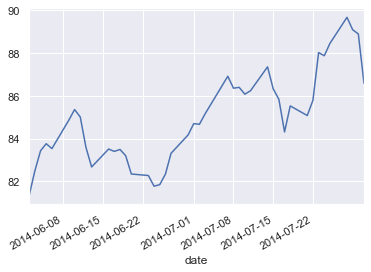

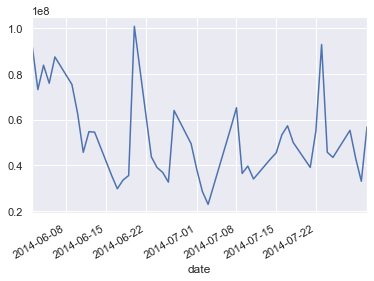

In [11]:
aapl['2014-06':'2014-07']['close'].plot()
plt.show()
aapl['2014-06':'2014-07']['volume'].plot();

In [12]:
del aapl

### FE
avoid leak of close price, use 1 day lag close price

refer to close price:
- 0) lag - 1day(close_pice),7day-carefull with this
- open price i will know
- will know yesterday low, hi, open, close(1day lag)
- min, max
- 1) MA+ std. different period - lon and short
- 2) EMA
- 3) MACD
- 4) slope
- 5) acc
- 6) sar
- 7) ADX
- 8) RSI?

refer to volume:
- 1) ?

In [86]:
def add_features(df):
    
    # prepare columns for finta module https://pypi.org/project/finta/
    ohlc= ['open', 'high', 'low', 'close']
    ohlcv = ['open', 'high', 'low', 'close', 'volume']


    ##### Get close price change for 1-15, 20, 25, 30 days ago

    # Percentage change between the current and a prior closing price
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html

    # Compare percentage change of today's price refernce to price of'lag' day ago
    lags = list(range(1,16))+[20,25,30]
    for i in lags:
        df[f'pct_lag_{i}']=df['close'].pct_change(periods=i)



    ##### Get the rolling mean and std deviation of pct_change

    # Compare percentage change of today's price refernce to price'lag' day ago
    lags = [1,5,10,15,10] 

    # Rolling windows = 5,10,15,20 days
    windows = [5,10,15,20] 
    for i in lags:
        for window in windows:
            df[f'pct_r_mean_{i}_{window}'] = df[f'pct_lag_{i}'].rolling(window).mean()
            df[f'pct_r_std_{i}_{window}'] = df[f'pct_lag_{i}'].rolling(window).std()


    ##### Get the exponential mean and std deviation of pct_change
    # finta.TA.EMA(df[ohlc],period=5) is the same df.close.ewm(span = 5).mean()

    # use pct_lag_1 here
    # use span = 5 and 10 periods or alpha = 2/(span+1)  (period is not the same as day)        
    df['pct_exp_mean_1_5'] = df['pct_lag_1'].ewm(span=5).mean()
    df['pct_exp_std_1_5'] = df['pct_lag_1'].ewm(span=5).std()

    df['pct_exp_mean_1_10'] = df['pct_lag_1'].ewm(span=10).mean()
    df['pct_exp_std_1_10'] = df['pct_lag_1'].ewm(span=10).std()


    ##### Get 'Direction'='MACD' - 'Signal'

    # MACD= 12_Period EMA − 26_Period EMA
    # https://www.investopedia.com/terms/m/macd.asp
    # df.close.ewm(span=12).mean()-df.close.ewm(span=26).mean() is the same as:
    # finta.TA.MACD(df[ohlc]), also returns 9 day signal line

    df['macd'] = (df.close.ewm(span=12).mean()-df.close.ewm(span=26).mean())

    # signal line is 9 period EMA of the MACD line
    df['signal']= df['macd'].ewm(span=9).mean()

    # diffrence between MACD and Signal line indicates bullish
    # or bearish direction of the market
    df['direction'] = df['macd']-df['signal']


    ##### Get 'slope' and 'acceleration'                          
    df['slope'] = df.close.rolling(9).apply(calc_slope,raw=False)
    df['acc'] = df.close.rolling(11).apply(calc_acc,raw=False)


    ### Get parabolic sar: 'stop and reverse'
    # https://www.investopedia.com/trading/introduction-to-parabolic-sar/
    # e.g value of af = 0.01  could keep in position longer time 
    df['sar'] = finta.TA.SAR(df[ohlc].copy(), af=0.025, amax=0.15)# not use as feature, plot only  
    
    # get normalized sar as signal: 
    #if 0<norm<1 then uptrend, if norm < 0, downtrend
    # here is an imballance possible, however as we do two separate models, 
    # for min and max target, may need to adjust
    df['sar_norm'] = 1- df.sar/df.close
    
    # do the same for moving avg 50,100,150,200
    windows=[50,100,150,200]
    
    # get normalized rolling_mean as signal: if 0<norm<1 then uptrend, if norm < 0, downtrend
    # here is an imballance possible, however as we do two separate models, 
    # for min and max target
    for win in windows: 
        df[f'r_mean_{win}'] = df.close.rolling(win).mean() # not use as feature, plot only
        df[f'r_mean_{win}_norm'] = 1 - df[f'r_mean_{win}']/df.close
    
    # macd: if short moving avg > long moving avg 
    # normalize: divide by short moving avg, and if 0<norm<1 then uptrend, if norm < 0, downtrend
    
    df[f'macd_50_100_norm'] = 1 - df[f'r_mean_100']/df[f'r_mean_50']
    df[f'macd_50_150_norm'] = 1 - df[f'r_mean_150']/df[f'r_mean_50']
    df[f'macd_50_200_norm'] = 1 - df[f'r_mean_200']/df[f'r_mean_50']
    df[f'macd_100_200_norm'] = 1 - df[f'r_mean_200']/df[f'r_mean_100']


    ### Get ADX: Average Directional Index
    # The A.D.X. is 100 * smoothed moving average of absolute value (DMI +/-) 
    # divided by (DMI+ + DMI-). ADX does not indicate trend direction or momentum,
    # only trend strength.
    # Here I normalised by dividing 30(assumed here above 30 is moderately strong trend).
    # https://www.investopedia.com/terms/a/adx.asp
    df['adx'] = (finta.TA.ADX(df[ohlc].copy(), period=14))/30


    ### Get RSI relative strength index is a momentum indicator
    # https://www.investopedia.com/terms/r/rsi.asp
    df['rsi'] = finta.TA.RSI(df[ohlc].copy(), period=14)

    df.dropna(inplace=True)
    
    
    
    #if 0<norm<1 then uptrend, if norm < 0, downtrend
    # here is an imballance possible, however as we do two separate models, 
    # for min and max target, may need to adjust
    
    #if norm < 1 uptrend, if norm > 1 downtrend
    

In [87]:
# # prepare columns for finta module https://pypi.org/project/finta/
# ohlc= ['open', 'high', 'low', 'close']
# ohlcv = ['open', 'high', 'low', 'close', 'volume']


# ##### Get close price change for 1-15, 20, 25, 30 days ago

# # Percentage change between the current and a prior closing price
# # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html

# # Compare percentage change of today's price refernce to price of'lag' day ago
# lags = list(range(1,16))+[20,25,30]
# for i in lags:
#     df[f'pct_lag_{i}']=df['close'].pct_change(periods=i)

    
    
# ##### Get the rolling mean and std deviation of pct_change

# # Compare percentage change of today's price refernce to price'lag' day ago
# lags = [1,5,10,15,10] 

# # Rolling windows = 5,10,15,20 days
# windows = [5,10,15,20] 
# for i in lags:
#     for window in windows:
#         df[f'pct_r_mean_{i}_{window}'] = df[f'pct_lag_{i}'].rolling(window).mean()
#         df[f'pct_r_std_{i}_{window}'] = df[f'pct_lag_{i}'].rolling(window).std()

        
# ##### Get the exponential mean and std deviation of pct_change
# # finta.TA.EMA(df[ohlc],period=5) is the same df.close.ewm(span = 5).mean()

# # use pct_lag_1 here
# # use span = 5 and 10 periods or alpha = 2/(span+1)  (period is not the same as day)        
# df['pct_exp_mean_1_5'] = df['pct_lag_1'].ewm(span=5).mean()
# df['pct_exp_std_1_5'] = df['pct_lag_1'].ewm(span=5).std()

# df['pct_exp_mean_1_10'] = df['pct_lag_1'].ewm(span=10).mean()
# df['pct_exp_std_1_10'] = df['pct_lag_1'].ewm(span=10).std()


# ##### Get 'Direction'='MACD' - 'Signal'

# # MACD= 12_Period EMA − 26_Period EMA
# # https://www.investopedia.com/terms/m/macd.asp
# # df.close.ewm(span=12).mean()-df.close.ewm(span=26).mean() is the same as:
# # finta.TA.MACD(df[ohlc]), also returns 9 day signal line

# df['macd'] = (df.close.ewm(span=12).mean()-df.close.ewm(span=26).mean())

# # signal line is 9 period EMA of the MACD line
# df['signal']= df['macd'].ewm(span=9).mean()

# # diffrence between MACD and Signal line indicates bullish
# # or bearish direction of the market
# df['direction'] = df['macd']-df['signal']


# ##### Get 'slope' and 'acceleration'                          
# df['slope'] = df.close.rolling(9).apply(calc_slope,raw=False)
# df['acc'] = df.close.rolling(11).apply(calc_acc,raw=False)


# ### Get parabolic sar: 'stop and reverse'
# # https://www.investopedia.com/trading/introduction-to-parabolic-sar/
# # e.g value of af = 0.01  could keep in position longer time 
# df['sar'] = finta.TA.SAR(df[ohlc].copy(), af=0.025, amax=0.15) 

# ### Get ADX: Average Directional Index
# # The A.D.X. is 100 * smoothed moving average of absolute value (DMI +/-) 
# # divided by (DMI+ + DMI-). ADX does not indicate trend direction or momentum,
# # only trend strength.
# # Here I normalised by dividing 30(assumed here above 30 is moderately strong trend).
# # https://www.investopedia.com/terms/a/adx.asp
# df['adx'] = (finta.TA.ADX(df[ohlc].copy(), period=14))/30


# ### Get RSI relative strength index is a momentum indicator
# # https://www.investopedia.com/terms/r/rsi.asp
# df['rsi'] = finta.TA.RSI(df[ohlc].copy(), period=14)






# df.dropna(inplace=True)

###  Get Targets based on closed price

In [88]:
def add_target(df):
    # get local minima and maxima (10 days both side from local extrema)
    df['target_min'] = loc_minima(df.close,order=10)
    df['target_max'] = loc_maxima(df.close,order=10)

    # get local extrema, its the same as above, just for plotting purpose
    # local minima(=1) and maxima(=-1)
    df['extrema'] = loc_extrema(df.close,order=10)

### TEST 1. Ticker: 'GSK'

In [89]:
gsk = df.loc[df["ticker"]=='GSK']
display(gsk,3,4)

,ticker,open,high,low,close,volume
date,,,,,,
2010-05-19,GSK,20.13,20.60,20.12,20.50,3683200.0
2010-05-20,GSK,20.07,20.24,19.83,19.94,2861300.0
2010-05-21,GSK,19.43,19.97,19.39,19.91,2500000.0
2020-05-13,GSK,42.19,42.70,42.07,42.27,5029500.0
2020-05-14,GSK,40.93,41.24,40.50,40.86,4829100.0
2020-05-15,GSK,40.60,40.99,40.46,40.91,2549700.0
2020-05-18,GSK,41.43,41.75,41.29,41.28,5307074.0


In [90]:
gsk.describe()

,open,high,low,close,volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,33.502332,33.692968,33.319130,33.512980,3.062274e+06
std,5.084735,5.098878,5.070088,5.082037,1.660461e+06
min,19.340000,19.690000,19.230000,19.340000,6.173000e+05
25%,30.650000,30.780000,30.480000,30.590000,2.011300e+06
50%,34.380000,34.590000,34.240000,34.410000,2.647500e+06
75%,36.760000,36.960000,36.560000,36.780000,3.597500e+06
max,47.080000,47.100000,46.660000,46.740000,2.160630e+07


In [91]:
add_features(gsk)
add_target(gsk)
gsk.columns

Index(['ticker', 'open', 'high', 'low', 'close', 'volume', 'pct_lag_1',
       'pct_lag_2', 'pct_lag_3', 'pct_lag_4', 'pct_lag_5', 'pct_lag_6',
       'pct_lag_7', 'pct_lag_8', 'pct_lag_9', 'pct_lag_10', 'pct_lag_11',
       'pct_lag_12', 'pct_lag_13', 'pct_lag_14', 'pct_lag_15', 'pct_lag_20',
       'pct_lag_25', 'pct_lag_30', 'pct_r_mean_1_5', 'pct_r_std_1_5',
       'pct_r_mean_1_10', 'pct_r_std_1_10', 'pct_r_mean_1_15',
       'pct_r_std_1_15', 'pct_r_mean_1_20', 'pct_r_std_1_20', 'pct_r_mean_5_5',
       'pct_r_std_5_5', 'pct_r_mean_5_10', 'pct_r_std_5_10', 'pct_r_mean_5_15',
       'pct_r_std_5_15', 'pct_r_mean_5_20', 'pct_r_std_5_20',
       'pct_r_mean_10_5', 'pct_r_std_10_5', 'pct_r_mean_10_10',
       'pct_r_std_10_10', 'pct_r_mean_10_15', 'pct_r_std_10_15',
       'pct_r_mean_10_20', 'pct_r_std_10_20', 'pct_r_mean_15_5',
       'pct_r_std_15_5', 'pct_r_mean_15_10', 'pct_r_std_15_10',
       'pct_r_mean_15_15', 'pct_r_std_15_15', 'pct_r_mean_15_20',
       'pct_r_std_15_20', 

In [20]:
# # get local minima(=1) and maxima(=-1) for 5,7,10 days
# df['target_10d'] = loc_extrema(df.close,order=10)

# ### order of 10 day 
# df['target_10d_min'] = df['target_10d'].copy()
# df['target_10d_min'].loc[df['target_10d_min'] == -1] = 0

# df['target_10d_max'] = df['target_10d'].copy()
# df['target_10d_max'].loc[df['target_10d_max'] == 1] = 0
# df['target_10d_max'].loc[df['target_10d_max'] == -1] = 1

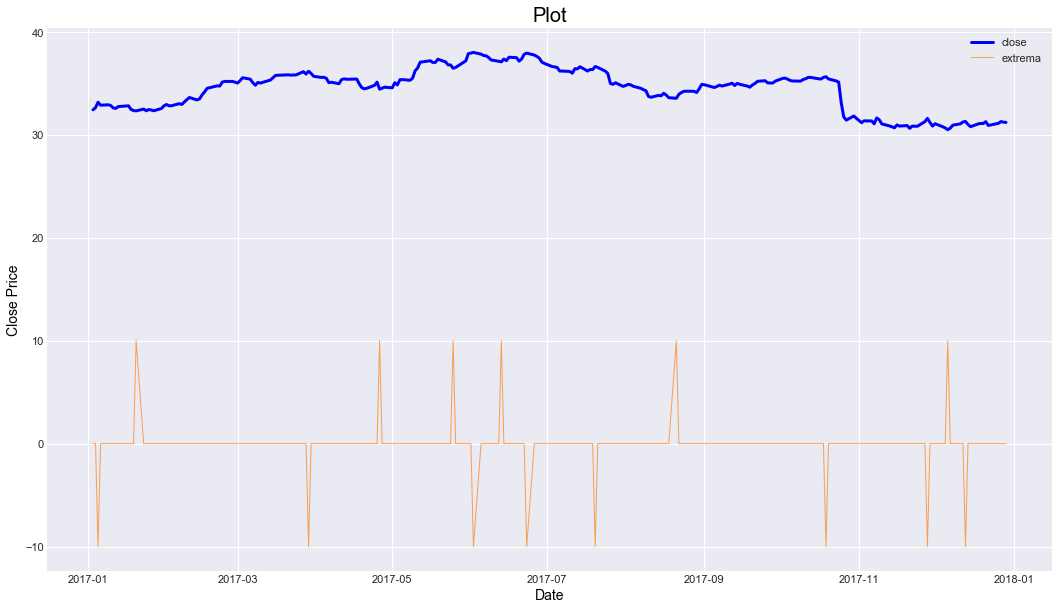

In [92]:
# plot for the year 2017 with order =10 day
columns = ['close','extrema']
scale = [1,10,10,20]
plot_df(gsk['2017'], columns, size = (18,10), scale = scale)

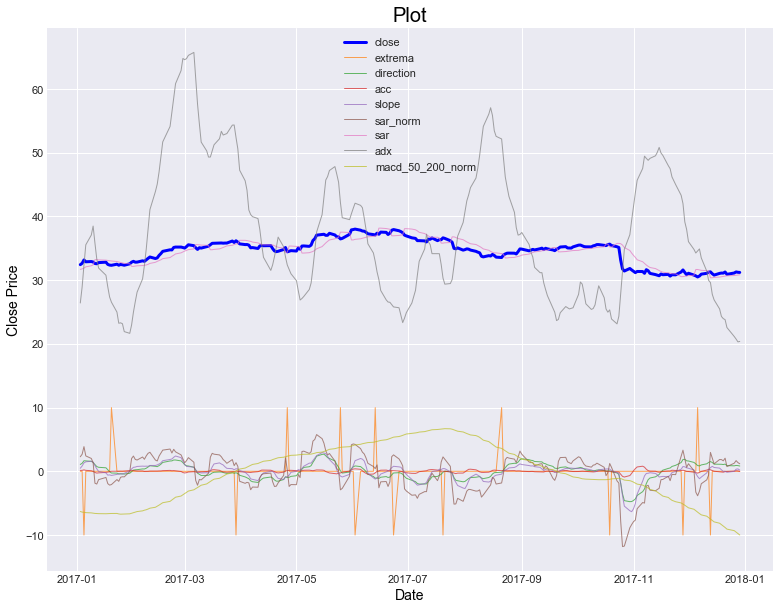

In [93]:
# plot for the year 2017 with order =10 day
columns = ['close','extrema','direction','acc','slope','sar_norm','sar','adx','macd_50_200_norm']
scale = [1,10,10,10,10,100,1,30,100]
plot_df(gsk['2017'], columns, size = (13,10), scale = scale)

In [94]:
used_cols = ['pct_lag_1','pct_lag_2', 'pct_lag_3', 'pct_lag_4', 
             'pct_lag_5', 'pct_lag_6','pct_lag_7', 'pct_lag_8', 'pct_lag_9', 
             'pct_lag_10', 'pct_lag_11','pct_lag_12', 'pct_lag_13', 'pct_lag_14',
             'pct_lag_15', 'pct_lag_20', 'pct_lag_25', 'pct_lag_30',
             'pct_r_mean_1_5','pct_r_std_1_5','pct_r_mean_1_10', 'pct_r_std_1_10',
             'pct_r_mean_1_15', 'pct_r_std_1_15', 'pct_r_mean_1_20', 'pct_r_std_1_20',
             'pct_r_mean_5_5','pct_r_std_5_5', 'pct_r_mean_5_10', 'pct_r_std_5_10',
             'pct_r_mean_5_15','pct_r_std_5_15', 'pct_r_mean_5_20', 'pct_r_std_5_20',
             'pct_r_mean_10_5', 'pct_r_std_10_5', 'pct_r_mean_10_10','pct_r_std_10_10',
             'pct_r_mean_10_15', 'pct_r_std_10_15','pct_r_mean_10_20', 'pct_r_std_10_20', 
             'pct_r_mean_15_5','pct_r_std_15_5', 'pct_r_mean_15_10', 'pct_r_std_15_10',
             'pct_r_mean_15_15', 'pct_r_std_15_15', 'pct_r_mean_15_20','pct_r_std_15_20',
             'pct_exp_mean_1_5', 'pct_exp_std_1_5','pct_exp_mean_1_10', 'pct_exp_std_1_10', 
             'r_mean_50_norm','r_mean_100_norm','r_mean_150_norm','r_mean_200_norm',
             'macd_50_100_norm', 'macd_50_150_norm','macd_50_200_norm', 'macd_100_200_norm',
             'direction','slope', 'acc', 'sar_norm', 'adx', 'rsi'] 
#'ticker', 'volume', 'macd', 'signal', 'sar', 'r_mean_50', 'r_mean_100','r_mean_150', 'r_mean_200',
# , 'target_min','target_max', 'extrema'

X = gsk[used_cols]
y = gsk['target_min']


### Vanilla LogReg

In [95]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### 
imputer = SimpleImputer()
scaler = RobustScaler()
pca = PCA(n_components=0.95, random_state = 42)
model = LogisticRegression(class_weight='balanced', random_state=42,C=10,solver = 'newton-cg',
                          fit_intercept=True,penalty='l2')
pipe = make_pipeline(imputer,scaler,pca,model)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')

print(scores.mean(), "+/-", scores.std())
scores

0.9152253892578747 +/- 0.022395934724564522


array([0.9199703 , 0.92932442, 0.94126674, 0.87544643, 0.91011905])


### XGBoost

In [96]:
from xgboost import XGBClassifier



pca = PCA(n_components=0.90, random_state = 42)
model = XGBClassifier()

pipe = make_pipeline(pca,model)

scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())
scores

0.9157119284587443 +/- 0.024423393820997525


array([0.89116555, 0.94328137, 0.94098772, 0.88452381, 0.91860119])

### ScoreCard

In [97]:
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
scaler = RobustScaler()
encoder = WOEEncoder(used_cols)
pca = PCA(n_components=0.90, random_state = 42)
model = LogisticRegression(class_weight='balanced', random_state=42,C=10,solver = 'lbfgs',
                          fit_intercept=True,penalty='l2')

pipe = make_pipeline(binner, scaler, encoder,pca, model)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')

print(scores.mean(), "+/-", scores.std())
scores

0.9221713264927353 +/- 0.01628038253165508


array([0.90319228, 0.93303638, 0.94754464, 0.90833333, 0.91875   ])

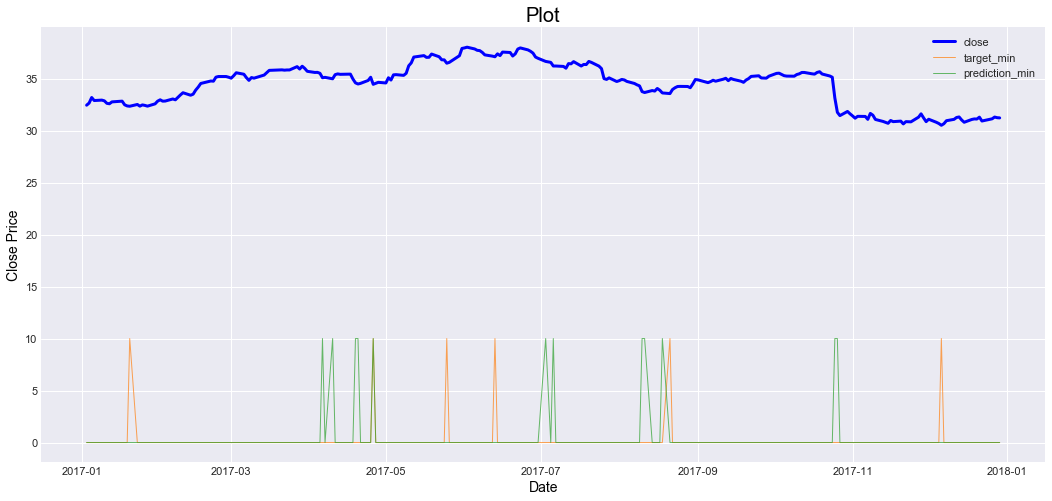

In [98]:
prediction  = (pipe.fit(X, y).predict_proba(X)[:,1] > 0.9).astype(np.int)
gsk['prediction_min'] = prediction
plot_df(gsk['2017'],['close','target_min','prediction_min'],scale=[1,10,10])

In [99]:
confusion_matrix(y,prediction)

array([[2119,  123],
       [  43,   33]])

### TEST 2. Ticker: 'HAE'


In [101]:
hae = df.loc[df["ticker"]=='HAE']
display(hae,3,4)

,ticker,open,high,low,close,volume
date,,,,,,
2010-05-19,HAE,28.04,28.21,27.77,28.07,245800.0
2010-05-20,HAE,27.83,27.88,27.24,27.25,383200.0
2010-05-21,HAE,27.18,27.27,26.81,27.14,506600.0
2020-05-13,HAE,99.33,99.58,95.64,97.43,418900.0
2020-05-14,HAE,97.06,100.49,96.19,100.44,355600.0
2020-05-15,HAE,100.43,101.53,98.41,100.37,352300.0
2020-05-18,HAE,101.72,105.75,101.72,103.37,438375.0


In [102]:
hae.describe()

,open,high,low,close,volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,51.827322,52.438458,51.227966,51.857934,3.658938e+05
std,29.375216,29.836324,28.903173,29.354605,2.962910e+05
min,25.500000,25.770000,25.250000,25.620000,5.940000e+04
25%,33.470000,33.790000,33.210000,33.520000,2.104000e+05
50%,39.500000,39.800000,39.110000,39.510000,2.949000e+05
75%,54.530000,55.190000,54.230000,54.920000,4.368000e+05
max,140.220000,140.360000,136.490000,138.520000,8.507700e+06


In [103]:
add_features(hae)
add_target(hae)
hae.columns

Index(['ticker', 'open', 'high', 'low', 'close', 'volume', 'pct_lag_1',
       'pct_lag_2', 'pct_lag_3', 'pct_lag_4', 'pct_lag_5', 'pct_lag_6',
       'pct_lag_7', 'pct_lag_8', 'pct_lag_9', 'pct_lag_10', 'pct_lag_11',
       'pct_lag_12', 'pct_lag_13', 'pct_lag_14', 'pct_lag_15', 'pct_lag_20',
       'pct_lag_25', 'pct_lag_30', 'pct_r_mean_1_5', 'pct_r_std_1_5',
       'pct_r_mean_1_10', 'pct_r_std_1_10', 'pct_r_mean_1_15',
       'pct_r_std_1_15', 'pct_r_mean_1_20', 'pct_r_std_1_20', 'pct_r_mean_5_5',
       'pct_r_std_5_5', 'pct_r_mean_5_10', 'pct_r_std_5_10', 'pct_r_mean_5_15',
       'pct_r_std_5_15', 'pct_r_mean_5_20', 'pct_r_std_5_20',
       'pct_r_mean_10_5', 'pct_r_std_10_5', 'pct_r_mean_10_10',
       'pct_r_std_10_10', 'pct_r_mean_10_15', 'pct_r_std_10_15',
       'pct_r_mean_10_20', 'pct_r_std_10_20', 'pct_r_mean_15_5',
       'pct_r_std_15_5', 'pct_r_mean_15_10', 'pct_r_std_15_10',
       'pct_r_mean_15_15', 'pct_r_std_15_15', 'pct_r_mean_15_20',
       'pct_r_std_15_20', 

In [108]:
used_cols = ['pct_lag_1','pct_lag_2', 'pct_lag_3', 'pct_lag_4', 
             'pct_lag_5', 'pct_lag_6','pct_lag_7', 'pct_lag_8', 'pct_lag_9', 
             'pct_lag_10', 'pct_lag_11','pct_lag_12', 'pct_lag_13', 'pct_lag_14',
             'pct_lag_15', 'pct_lag_20', 'pct_lag_25', 'pct_lag_30',
             'pct_r_mean_1_5','pct_r_std_1_5','pct_r_mean_1_10', 'pct_r_std_1_10',
             'pct_r_mean_1_15', 'pct_r_std_1_15', 'pct_r_mean_1_20', 'pct_r_std_1_20',
             'pct_r_mean_5_5','pct_r_std_5_5', 'pct_r_mean_5_10', 'pct_r_std_5_10',
             'pct_r_mean_5_15','pct_r_std_5_15', 'pct_r_mean_5_20', 'pct_r_std_5_20',
             'pct_r_mean_10_5', 'pct_r_std_10_5', 'pct_r_mean_10_10','pct_r_std_10_10',
             'pct_r_mean_10_15', 'pct_r_std_10_15','pct_r_mean_10_20', 'pct_r_std_10_20', 
             'pct_r_mean_15_5','pct_r_std_15_5', 'pct_r_mean_15_10', 'pct_r_std_15_10',
             'pct_r_mean_15_15', 'pct_r_std_15_15', 'pct_r_mean_15_20','pct_r_std_15_20',
             'pct_exp_mean_1_5', 'pct_exp_std_1_5','pct_exp_mean_1_10', 'pct_exp_std_1_10', 
             'r_mean_50_norm','r_mean_100_norm','r_mean_150_norm','r_mean_200_norm',
             'macd_50_100_norm', 'macd_50_150_norm','macd_50_200_norm', 'macd_100_200_norm',
             'direction','slope', 'acc', 'sar_norm', 'adx', 'rsi'] 
#'ticker', 'volume', 'macd', 'signal', 'sar', 'r_mean_50', 'r_mean_100','r_mean_150', 'r_mean_200',
# , 'target_min','target_max', 'extrema'

X = hae[used_cols]
y = hae['target_min']


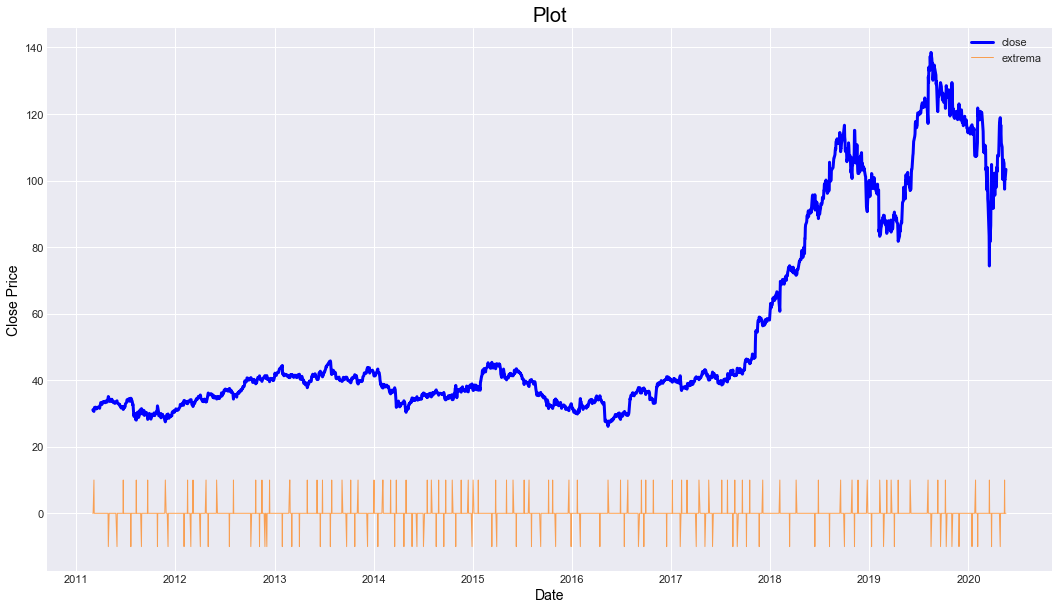

In [109]:
# plot with order =10 day
columns = ['close','extrema']
scale = [1,10]
plot_df(hae, columns, size = (18,10), scale = scale)

### Vanilla LogReg

In [110]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### 
imputer = SimpleImputer()
scaler = RobustScaler()
pca = PCA(n_components=0.9, random_state = 42)
model = LogisticRegression(class_weight='balanced', random_state=42,C=10,solver = 'newton-cg',
                          fit_intercept=True,penalty='l2')
pipe = make_pipeline(imputer,scaler,pca,model)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')

print(scores.mean(), "+/-", scores.std())
scores

0.9282323919500686 +/- 0.018693069678863646


array([0.92047991, 0.94335938, 0.89840769, 0.95204139, 0.9268736 ])

In [111]:
### XGBoost

In [112]:
from xgboost import XGBClassifier



pca = PCA(n_components=0.9, random_state = 42)
model = XGBClassifier()

pipe = make_pipeline(pca,model)

scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())
scores

0.9323624400473276 +/- 0.014773501603744259


array([0.93415179, 0.92145647, 0.91169891, 0.95427852, 0.94022651])

### Scorecard

In [113]:
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
scaler = RobustScaler()
encoder = WOEEncoder(used_cols)
pca = PCA(n_components=0.9, random_state = 42)
model = LogisticRegression(class_weight='balanced', random_state=42,C=10,solver = 'lbfgs',
                          fit_intercept=True,penalty='l2')

pipe = make_pipeline(binner, scaler, encoder,pca, model)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')

print(scores.mean(), "+/-", scores.std())
scores

0.9370237529785402 +/- 0.009840033472035069


array([0.9296875 , 0.93987165, 0.92196342, 0.94532998, 0.94826622])

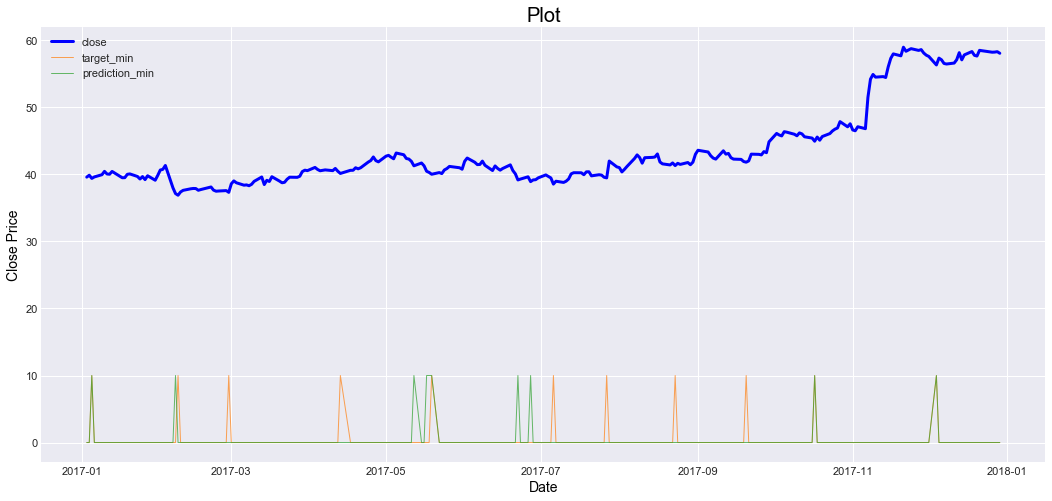

In [114]:
prediction  = (pipe.fit(X, y).predict_proba(X)[:,1] > 0.9).astype(np.int)
hae['prediction_min'] = prediction
plot_df(hae['2017'],['close','target_min','prediction_min'],scale=[1,10,10])

In [115]:
# ### test on 20 shares:
# shares_20=['EIX','IDA','CORT','FLO','GFI','RSG','MCO','TFSL','MCY','INVA',
#              'VGR','BILI','CFFN','MKC','D','NRG','CSGS','WBC','VMW','CWST']
# df_20 = df.loc[df['ticker'].apply(lambda x: x in shares_20)]
# display(df_20,3,4)

In [116]:
# df_20.ticker.nunique()

In [117]:
# # add_features(df_20)
# # add_target(df_20)
# # df_20.columns
# df.groupby(by='ticker')